# AvatarGAN
_Generate Cartoon Images using GAN_


## Connect Google Drive

Mount the Google Drive to Google Colab

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully!")
    %tensorflow_version 2.x
except Exception as e:
    print("Error while mounting Google Drive: {}".format(str(e)))

Mounted at /content/drive
Google Drive mounted successfully!


## Import libraries


In [ ]:
import os, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam



In [ ]:
# Convert seconds to HH:MM:SS.MI format
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
IMAGE_CHANNELS = 3
GENERATE_RESOLUTION_FACTOR = 3
GENERATE_SQUARE = 32 * GENERATE_RESOLUTION_FACTOR

# Preview image details
PREVIEW_ROWS, PREVIEW_COLS = 4, 7
PREVIEW_MARGIN = 16

# Source vector size to generate images
SEED_SIZE = 100

# Model configuration
DATA_PATH = '/content/drive/My Drive/projects/cartoons/'
FOLDER_NAME = 'cartoonset30k'

EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 61000

print(f"Image details: {GENERATE_SQUARE}px")

Image details: 96px


# Load the Dataset

We have a lot of images to read and process and this task can take a while. So, we will real all the iamges, convert it to JPG format, resize it, normalize it and store the processed file as binary.

We are using Numpy binary instead of Pickle because the file is very large and may cause problems with some versions of Pickle.


In [ ]:
training_binary_path = os.path.join(DATA_PATH, 
    f'training_data_{FOLDER_NAME}_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
print("Binary file name: ", training_binary_path)

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("File not found, loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH, FOLDER_NAME)
  faces_path_filenames = os.listdir(faces_path)
  for filename in tqdm(faces_path_filenames):
      path = os.path.join(faces_path,filename)
      # Convert RGBA to RGB format
      try:
        image = Image.open(path).convert("RGB").resize((GENERATE_SQUARE,
              GENERATE_SQUARE),Image.ANTIALIAS)
        training_data.append(np.asarray(image))
      except Exception as e:
        # print(f'[Error] image: {image}, exception: {e}')
        pass
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary file...")
  np.save(training_binary_path,training_data)
  stop = time.time()-start
  print (f'Image preprocess time: {hms_string(stop)}')
else:
  print("Loading previous training binary file...")
  load_data_start_time = time.time()
  training_data = np.load(training_binary_path)
  load_data_tat = time.time() - load_data_start_time
  print("Data load time: ", hms_string(load_data_tat))

Binary file name:  /content/drive/My Drive/projects/cartoons/training_data_cartoonset30k_96_96.npy
Loading previous training binary file...
Data load time:  0:01:24.00


In [ ]:
# Shuffle the dataset and create batches
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print("Length of total images: ", len(training_data))
print("Length of total batches: ", len(train_dataset))
print("Length of images in one batch: ", len(list(train_dataset.as_numpy_iterator())[0]))

Length of total images:  27547
Length of total batches:  431
Length of images in one batch:  64


## Define the Models

We will use [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model) to define the models.


### Generator

The generator needs upsampling layers to produce an image from random noise. We start with a `Dense` layer whose input is seed and then apply [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) to upsample it several times until we reach the output shape of `96x96x3`. We are using `LeakyReLU` activation for middle layers and `tanh` for output layer.

In [ ]:
def build_generator(seed_size, channels):
  model = Sequential()

  model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((4, 4, 256)))
  
  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 32, 32, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 96, 96, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 96, 96, 3)
  
  return model

### The Discriminator

Discriminator is a CNN image classifier.

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

Save the generated images during training to check the training progress.

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  
  fig = plt.figure(figsize=(15,15))
  plt.imshow(im)
  plt.show()
  im.save(filename)

Lets plot the image created by untrained Generator.

Generated image shape:  (1, 96, 96, 3)


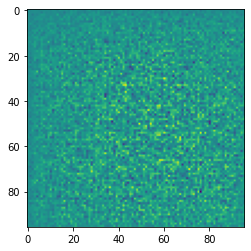

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
print("Generated image shape: ", generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49997973]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

We will use the Binary Cross-Entropy loss function. BCE cost function has two parts, one relevant for each class. The value is close to zero when the label and prediction are similar but approaches infinity when the label and the prediction are different.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both Generator and Discriminator model uses Adam optimizer and the same learning rate and momentum.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

## Training Pipeline

The training function is decorated by `tf.function annotation` which causes the function to be precompiled and improves performance.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  # generate_and_save_images(generator, epochs, seed)
  return gen_loss,disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


Train the two neural networks independently in two separate passes.

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    
    display.clear_output(wait=True)
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  display.clear_output(wait=True)
  print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
  save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

## Train the model

Call the `train()` method defined above to train the generator and discriminator simultaneously. 

Epoch 50, gen loss=5.557322978973389,disc loss=0.3461451828479767, time=0:01:41.89


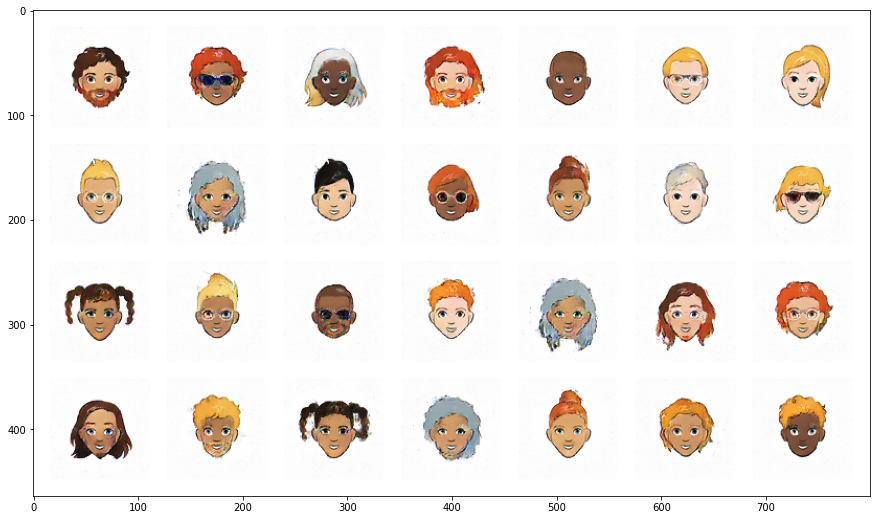

Training time: 1:25:40.74


In [ ]:
train(train_dataset, EPOCHS)


In [ ]:
name = f"face_generator_{EPOCHS}.h5"
generator.save(os.path.join(DATA_PATH, name))